# Lab | Imbalanced data

In [89]:
import pymysql
from sqlalchemy import create_engine
from scipy import stats
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
password = getpass.getpass()

········


 ### 1. Load the dataset and explore the variables.

In [90]:
data = pd.read_csv(r'C:\Users\claud\lab-imbalanced-data\files_for_lab\customer_churn.csv')

In [91]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [92]:
data.shape

(7043, 21)

In [93]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [94]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [95]:
data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### 2. We will try to predict variable `Churn` using a logistic regression on variables `tenure`, `SeniorCitizen`,`MonthlyCharges`.

In [96]:
# creating a data frame with the mentioned variables
data1 = data[['tenure', 'SeniorCitizen', 'MonthlyCharges', 'Churn']].copy()
data1.head()

,tenure,SeniorCitizen,MonthlyCharges,Churn
0,1,0,29.85,No
1,34,0,56.95,No
2,2,0,53.85,Yes
3,45,0,42.30,No
4,2,0,70.70,Yes


In [97]:
# checking columns distributions
for col in data1:
    print(data1[col].value_counts(), '\n')

1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: tenure, Length: 73, dtype: int64 

0    5901
1    1142
Name: SeniorCitizen, dtype: int64 

20.05     61
19.85     45
19.90     44
19.95     44
19.65     43
          ..
87.65      1
35.30      1
114.85     1
56.50      1
97.25      1
Name: MonthlyCharges, Length: 1585, dtype: int64 

No     5174
Yes    1869
Name: Churn, dtype: int64 



In [98]:
# treating variables as categoricals
data1['SeniorCitizen'] = data1['SeniorCitizen'].astype('object')
data1.dtypes

tenure              int64
SeniorCitizen      object
MonthlyCharges    float64
Churn              object
dtype: object

### 3. Extract the target variable.

In [99]:
y = data1['Churn']
X = data1.drop('Churn', axis=1)

In [100]:
X = pd.get_dummies(X)
X

,tenure,MonthlyCharges,SeniorCitizen_0,SeniorCitizen_1
0,1,29.85,1,0
1,34,56.95,1,0
2,2,53.85,1,0
3,45,42.30,1,0
4,2,70.70,1,0
...,...,...,...,...
7038,24,84.80,1,0
7039,72,103.20,1,0
7040,11,29.60,1,0
7041,4,74.40,0,1


### 4. Extract the independent variables and scale them.

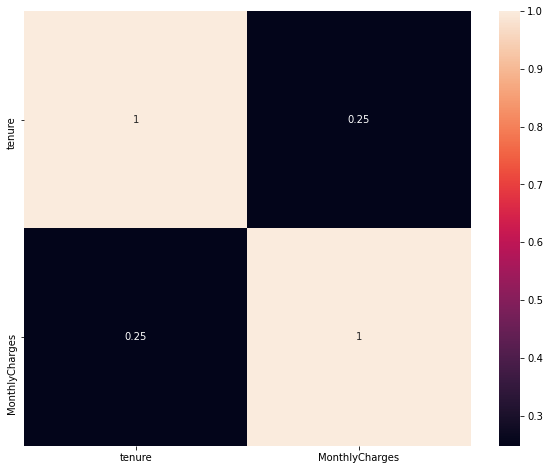

In [101]:
corr_matrix = data1.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

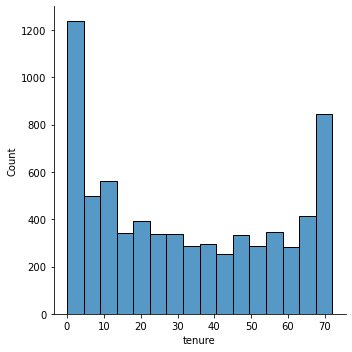

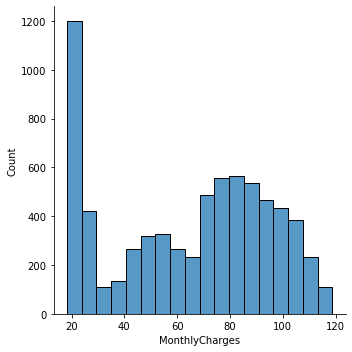

In [64]:
for col in data1.select_dtypes(np.number):
    sns.displot(data1[col])
    plt.show()

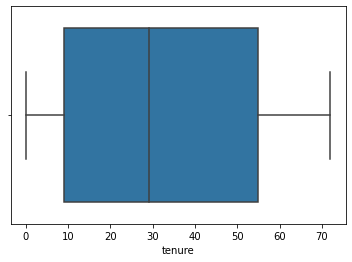

In [102]:
sns.boxplot(x=data1['tenure'])
plt.show()

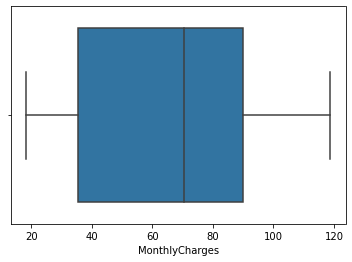

In [103]:
sns.boxplot(x=data1['MonthlyCharges'])
plt.show()

In [104]:
def boxcox_transform(df):
    numeric_cols = df.select_dtypes(np.number).columns
    _ci = {column: None for column in numeric_cols}
    for column in numeric_cols:
        # since i know any columns should take negative numbers, to avoid -inf in df
        df[column] = np.where(df[column]<=0, np.NAN, df[column]) 
        df[column] = df[column].fillna(df[column].mean())
        transformed_data, ci = stats.boxcox(df[column])
        df[column] = transformed_data
        _ci[column] = [ci] 
    return df, _ci

df, _ci = boxcox_transform(data1)
df

,tenure,SeniorCitizen,MonthlyCharges,Churn
0,0.000000,0,23.578295,No
1,8.796285,0,43.571734,No
2,0.815814,0,41.332735,Yes
3,10.300457,0,32.892530,No
4,0.815814,0,53.391036,Yes
...,...,...,...,...
7038,7.177193,0,63.300009,No
7039,13.299215,0,76.033726,No
7040,4.364654,0,23.388387,No
7041,1.936485,1,56.005603,Yes


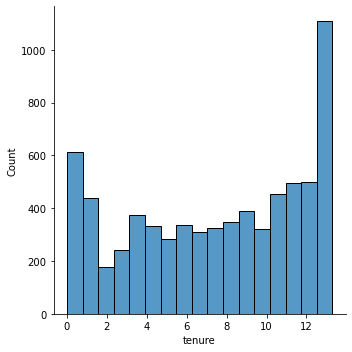

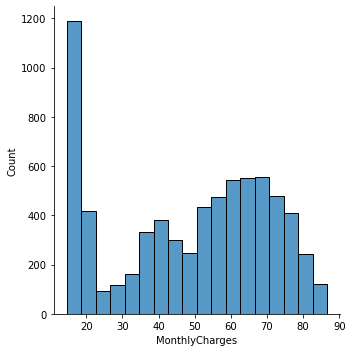

In [105]:
for col in data1.select_dtypes(np.number):
    sns.displot(data1[col])
    plt.show()

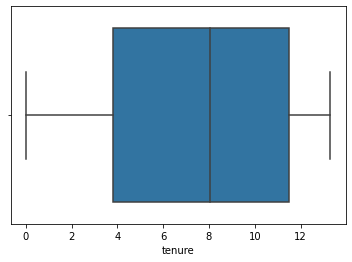

In [106]:
sns.boxplot(x=data1['tenure'])
plt.show()

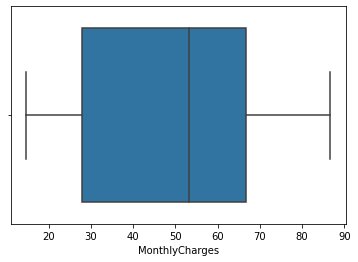

In [107]:
sns.boxplot(x=data1['MonthlyCharges'])
plt.show()

In [108]:
# removing outliers - not necessary as the boxplot didn't show many of them
#for col in data1.select_dtypes(np.number):
#   iqr = np.percentile(data1[col],75) - np.percentile(data1[col],25)
#    upper_limit = np.percentile(data1[col], 75) + 1.5 * iqr
#    lower_limit = np.percentile(data1[col], 25) - 1.5 * iqr
#    data1 = data1[(data1[col]>lower_limit) & (data1[col]<upper_limit)]
#data1.head()

In [109]:
# Checking data after outliers remotion
#sns.boxplot(x=cat['tenure'])
#plt.show()

In [110]:
#sns.boxplot(x=cat['MonthlyCharges'])
#plt.show()

### 5. Build the logistic regression model.

In [111]:
data1['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [113]:
classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

### 6. Evaluate the model.

In [114]:
classification.score(X_test, y_test)

0.8062455642299503

In [115]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

          No       0.83      0.92      0.88      1036
         Yes       0.69      0.48      0.57       373

    accuracy                           0.81      1409
   macro avg       0.76      0.70      0.72      1409
weighted avg       0.80      0.81      0.79      1409



In [116]:
predictions = classification.predict(X_test)
confusion_matrix(y_test, predictions)

array([[956,  80],
       [193, 180]], dtype=int64)

<AxesSubplot:>

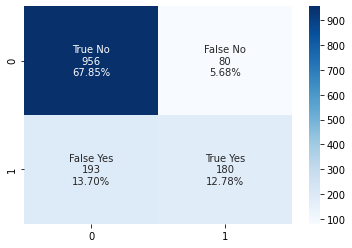

In [117]:
cf_matrix = confusion_matrix(y_test, predictions)
group_names = ['True No', 'False No',
               'False Yes', 'True Yes']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

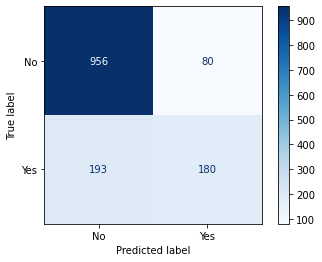

In [118]:
plot_confusion_matrix(classification, X_test, y_test, cmap='Blues')
plt.show()

### 7. Even a simple model will give us more than 70% accuracy. Why?

"Accuracy Paradox
Accuracy can be misleading. Sometimes it may be desirable to select a model with a lower accuracy because it has a greater predictive power on the problem.

For example, in a problem where there is a large class imbalance, a model can predict the value of the majority class for all predictions and achieve a high classification accuracy, the problem is that this model is not useful in the problem domain. 

This is called the Accuracy Paradox. For problems like, this additional measures are required to evaluate a classifier."

Source: https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/

### 8. Synthetic Minority Oversampling TEchnique (SMOTE) is an over sampling technique based on nearest neighbors that adds new points between existing points. Apply `imblearn.over_sampling.SMOTE` to the dataset. Build and evaluate the logistic regression model. Is it there any improvement?

I did the first time with SMOTE and got a score of 0.8062455642299503

In [119]:
# dealing with imbalanced data by SMOTE
smote = SMOTE()

X_sm, y_sm = smote.fit_resample(X, y)
y_sm.value_counts()

No     5174
Yes    5174
Name: Churn, dtype: int64

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [121]:
# I got the exact same result, so I think I did something really wrong... ops!
classification.score(X_test, y_test)

0.8062455642299503

In [122]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

          No       0.83      0.92      0.88      1036
         Yes       0.69      0.48      0.57       373

    accuracy                           0.81      1409
   macro avg       0.76      0.70      0.72      1409
weighted avg       0.80      0.81      0.79      1409



### 9. Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process. Apply `imblearn.under_sampling.TomekLinks` to the dataset. Build and evaluate the logistic regression model. Is it there any improvement?

In [123]:
X = data1.drop('Churn', axis=1)
y = data1['Churn']

tomek = TomekLinks()
X_tl, y_tl = tomek.fit_resample(X, y)
y_tl.value_counts()

## Ooops - good for smaller imbalances -> still looking not the best

No     4697
Yes    1869
Name: Churn, dtype: int64

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [125]:
classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [126]:
# The score is lower after applying this technique
classification.score(X_test, y_test)

0.801277501774308

In [128]:
# The other metrics still the same
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

          No       0.83      0.92      0.88      1036
         Yes       0.69      0.48      0.57       373

    accuracy                           0.81      1409
   macro avg       0.76      0.70      0.72      1409
weighted avg       0.80      0.81      0.79      1409

